In [1]:
'''
To do: 
++++++++++++++++++++++++++++++++++++++++++++++++++++
- continue training when training is interupted
- modify the transformer to better process time series/eeg
- do a scaling stduy on this dataset if possible
- hyperparameter tuning 


'''

'\nTo do: \n++++++++++++++++++++++++++++++++++++++++++++++++++++\n- continue training when training is interupted\n- modify the transformer to better process time series/eeg\n- do a scaling stduy on this dataset if possible\n- hyperparameter tuning \n\n\n'

In [1]:
import gc
import math
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
import os
import pandas as pd
import random
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from glob import glob
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import OneCycleLR
from tqdm.notebook import tqdm
from typing import Dict, List

os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using', torch.cuda.device_count(), 'GPU(s)')
!mkdir models

Using 1 GPU(s)
mkdir: cannot create directory 'models': File exists


# <b><span style='color:#F1A424'>|</span> Configuration</b><a class='anchor' id='configuration'></a> [↑](#top) 

***

In [2]:
class config:
    AMP = True
    TRAIN_VAL_RATIO = 0.95
    BATCH_SIZE_TRAIN = 7
    BATCH_SIZE_VALID = 7
    EPOCHS = 5
    GRADIENT_ACCUMULATION_STEPS = 4
    MAX_GRAD_NORM = 1e7
    NUM_WORKERS = 0 # multiprocessing.cpu_count()
    PRINT_FREQ = 20
    SEED = 20
    TRAIN_FULL_DATA = False
    VISUALIZE = True
    WEIGHT_DECAY = 0.01

   
    goofy_ahh_var = False 
    
    
class paths:
    OUTPUT_DIR = "/kaggle/working/"
    TRAIN_CSV = "/kaggle/input/hms-harmful-brain-activity-classification/train.csv"
    TRAIN_EEGS = "/kaggle/input/hms-harmful-brain-activity-classification/train_eegs/"

# <b><span style='color:#F1A424'>|</span> Utils</b><a class='anchor' id='utils'></a> [↑](#top) 

***

Utility functions.

In [3]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s: float):
    "Convert to minutes."
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since: float, percent: float):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def eeg_from_parquet(parquet_path: str, display: bool = False) -> np.ndarray:
    """
    This function reads one parquet file and extracts the middle 50 seconds of readings. Then it fills NaN values
    with the mean value (ignoring NaNs).
    :param parquet_path: path to parquet file.
    :param display: whether to display EEG plots or not.
    :return data: np.array of shape  (time_steps, eeg_features) -> (10_000, 8)
    """
    # === Extract middle 50 seconds ===
    eeg = pd.read_parquet(parquet_path, columns=eeg_features)
    rows = len(eeg)
    offset = (rows - 10_000) // 2 # 50 * 200 = 10_000
    eeg = eeg.iloc[offset:offset+10_000] # middle 50 seconds, has the same amount of readings to left and right
    if display: 
        plt.figure(figsize=(10,5))
        offset = 0
    # === Convert to numpy ===
    data = np.zeros((10_000, len(eeg_features))) # create placeholder of same shape with zeros
    for index, feature in enumerate(eeg_features):
        x = eeg[feature].values.astype('float32') # convert to float32
        mean = np.nanmean(x) # arithmetic mean along the specified axis, ignoring NaNs
        nan_percentage = np.isnan(x).mean() # percentage of NaN values in feature
        # === Fill nan values ===
        if nan_percentage < 1: # if some values are nan, but not all
            x = np.nan_to_num(x, nan=mean)
        else: # if all values are nan
            x[:] = 0 # convert all nans to zero
        data[:, index] = x # set the currnet column of the data to the feature
        if display: 
            if index != 0:
                offset += x.max()
            plt.plot(range(10_000), x-offset, label=feature)
            offset -= x.min()
    if display:
        plt.legend()
        name = parquet_path.split('/')[-1].split('.')[0]
        plt.yticks([])
        plt.title(f'EEG {name}',size=16)
        plt.show()    
    return data
    
def sep():
    print("-"*100)

    
target_preds = [x + "_pred" for x in ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']]
label_to_num = {'Seizure': 0, 'LPD': 1, 'GPD': 2, 'LRDA': 3, 'GRDA': 4, 'Other':5}
num_to_label = {v: k for k, v in label_to_num.items()}

# <b><span style='color:#F1A424'>|</span> Load Data</b><a class='anchor' id='load_data'></a> [↑](#top) 

***

Load the competition's data.

In [91]:
train_df = pd.read_csv(paths.TRAIN_CSV)
label_cols = train_df.columns[-6:]
print(f"Train cataframe shape is: {train_df.shape}")
print(f"Labels: {list(label_cols)}")

Train cataframe shape is: (106800, 15)
Labels: ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']


In [92]:
# sample eeg
eeg_df = pd.read_parquet(paths.TRAIN_EEGS + "100261680.parquet")
eeg_features = eeg_df.columns
print(f'There are {len(eeg_features)} raw eeg features')
print(list(eeg_features))
eeg_features = ['Fp1','T3','C3','O1','Fp2','C4','T4','O2']
feature_to_index = {x:y for x,y in zip(eeg_features, range(len(eeg_features)))}

There are 20 raw eeg features
['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 'Fz', 'Cz', 'Pz', 'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2', 'EKG']


In [93]:
feature_to_index

{'Fp1': 0, 'T3': 1, 'C3': 2, 'O1': 3, 'Fp2': 4, 'C4': 5, 'T4': 6, 'O2': 7}

In [24]:
eeg_lens = []

for i, eeg_id in tqdm(enumerate(eeg_ids)):  
    # Save EEG to Python dictionary of numpy arrays
    eeg_path = paths.TRAIN_EEGS + str(eeg_id) + ".parquet"
    eeg = pd.read_parquet(eeg_path, columns=eeg_features)
    eeg_lens.append(len(eeg))

0it [00:00, ?it/s]

In [29]:
eeg_lens = np.sort(eeg_lens)

(array([1.6979e+04, 7.5000e+01, 1.9000e+01, 6.0000e+00, 2.0000e+00,
        2.0000e+00, 2.0000e+00, 2.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([ 10000.,  77440., 144880., 212320., 279760., 347200., 414640.,
        482080., 549520., 616960., 684400.]),
 <BarContainer object of 10 artists>)

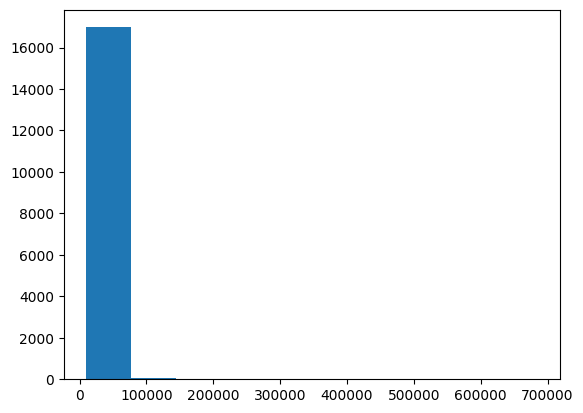

In [33]:
plt.hist(eeg_lens)

In [36]:
np.unique(eeg_lens, return_counts=True)

(array([ 10000,  10400,  10800,  11200,  11600,  12000,  12400,  12800,
         13200,  13600,  14000,  14400,  14800,  15200,  15600,  16000,
         16400,  16800,  17200,  17600,  18000,  18400,  18800,  19200,
         19600,  20000,  20400,  20800,  21200,  21600,  22000,  22400,
         22800,  23200,  23600,  24000,  24400,  24800,  25200,  25600,
         26000,  26400,  26800,  27200,  27600,  28000,  28400,  28800,
         29200,  29600,  30000,  30400,  30800,  31200,  31600,  32000,
         32400,  32800,  33200,  33600,  34000,  34400,  34800,  35200,
         35600,  36000,  36400,  36800,  37200,  37600,  38000,  38400,
         38800,  39200,  39600,  40000,  40400,  40800,  41200,  41600,
         42000,  42400,  42800,  43200,  43600,  44000,  44400,  44800,
         45200,  45600,  46000,  46400,  46800,  47200,  47600,  48000,
         48400,  48800,  49200,  49600,  50000,  50400,  50800,  51200,
         51600,  52000,  52400,  52800,  53200,  53600,  54000, 

In [25]:
np.mean(eeg_lens)

16022.096085201007

0it [00:00, ?it/s]

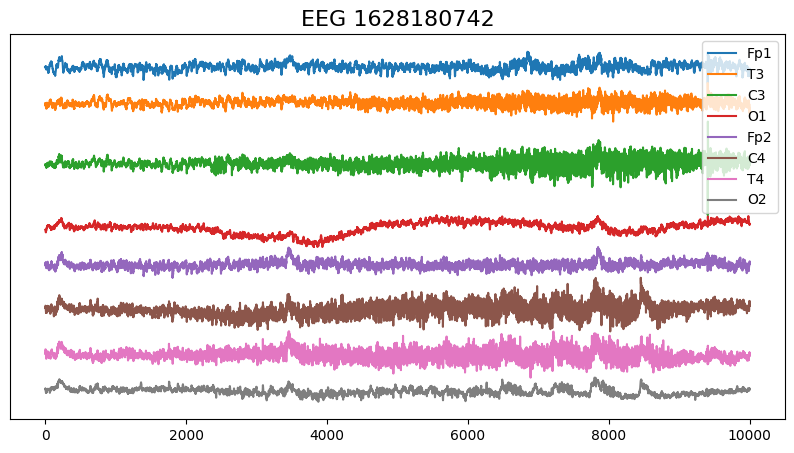

Processing 17089 eeg parquets... 

In [7]:
all_eegs = {}
visualize = 1
eeg_paths = glob(paths.TRAIN_EEGS + "*.parquet")
eeg_ids = train_df.eeg_id.unique()

for i, eeg_id in tqdm(enumerate(eeg_ids)):  
    # Save EEG to Python dictionary of numpy arrays
    eeg_path = paths.TRAIN_EEGS + str(eeg_id) + ".parquet"
    data = eeg_from_parquet(eeg_path, display=i<visualize)              
    all_eegs[eeg_id] = data
    
    if i == visualize:
        print(f'Processing {train_df.eeg_id.nunique()} eeg parquets... ',end='')
       

In [11]:
np.save('all_eegs',all_eegs)

In [ ]:
all_eegs = np.load('all_eegs.npy')

In [15]:
all_eegs[1628180742].shape # first eeg sample
# this is 50 seconds worth of eeg data and 8 features 

(10000, 8)

In [95]:
CREATE_EEGS = False
visualize = 1
eeg_paths = glob(paths.TRAIN_EEGS + "*.parquet")
eeg_ids = train_df.eeg_id.unique()
eeg_ids

array([1628180742, 2277392603,  722738444, ..., 1850739625, 1306668185,
        351917269])

# <b><span style='color:#F1A424'>|</span> Data pre-processing</b><a class='anchor' id='preprocessing'></a> [↑](#top) 

***

In [54]:
df

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106795,351917269,6,12.0,2147388374,6,12.0,4195677307,10351,LRDA,0,0,0,3,0,0
106796,351917269,7,14.0,2147388374,7,14.0,290896675,10351,LRDA,0,0,0,3,0,0
106797,351917269,8,16.0,2147388374,8,16.0,461435451,10351,LRDA,0,0,0,3,0,0
106798,351917269,9,18.0,2147388374,9,18.0,3786213131,10351,LRDA,0,0,0,3,0,0


In [96]:
df = pd.read_csv(paths.TRAIN_CSV)
label_cols = df.columns[-6:]

# the agg('first') function is applied to each group. This function takes the first element of the group
train_df = df.groupby('eeg_id')[['patient_id']].agg('first') # selects unique eeg_ids by using .agg('first'). In that df, the only data is 'patient_id'
aux = df.groupby('eeg_id')[label_cols].agg('sum') # for each eeg_id, sum the label_cols values

for label in label_cols:
    train_df[label] = aux[label].values
    
    
y_data = train_df[label_cols].values
y_data = y_data / y_data.sum(axis=1,keepdims=True)
train_df[label_cols] = y_data

aux = df.groupby('eeg_id')[['expert_consensus']].agg('first')
train_df['target'] = aux

train_df = train_df.reset_index()
train_df = train_df.loc[train_df.eeg_id.isin(eeg_ids)]
print(f"Train dataframe with unique eeg_id has shape: {train_df.shape}")

Train dataframe with unique eeg_id has shape: (17089, 9)


# <b><span style='color:#F1A424'>|</span> Butter Low-Pass Filter</b><a class='anchor' id='filter'></a> [↑](#top) 

***

- [scipy.signal.butter()][1]
- [scipy.signal.lfilter()][2]

[1]: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html#scipy.signal.butter
[2]: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lfilter.html#scipy.signal.lfilter

In [97]:
from scipy.signal import butter, lfilter

def butter_lowpass_filter(data, cutoff_freq: int = 8, sampling_rate: int = 200, order: int = 4):
    nyquist = 0.5 * sampling_rate
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = lfilter(b, a, data, axis=0)
    return filtered_data

## <b><span style='color:#F1A424'>Visualize</span></b>


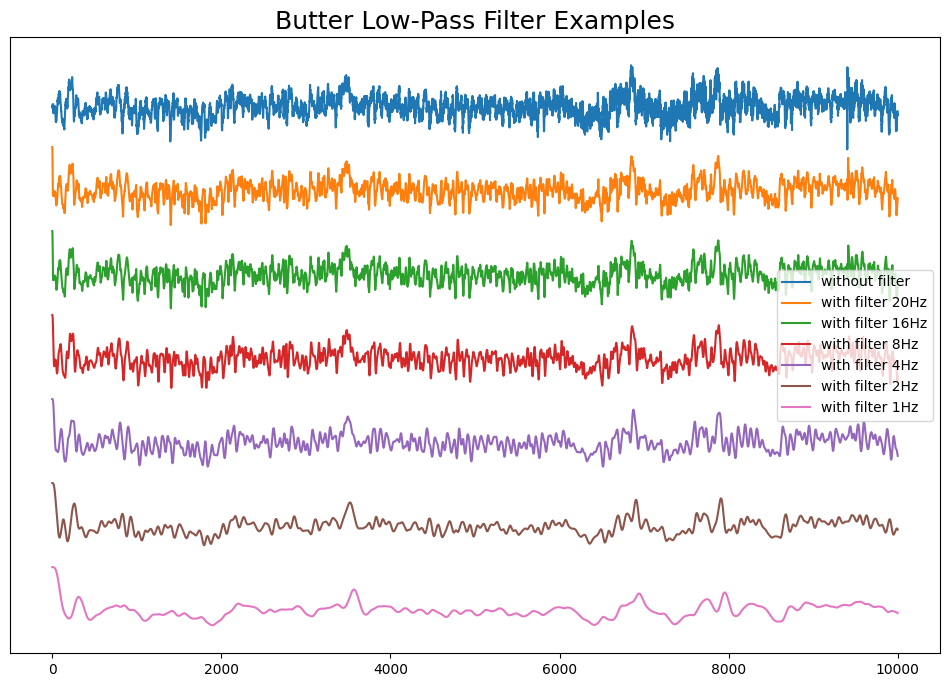

In [73]:
frequencies = [1,2,4,8,16,20][::-1] # frequencies in Hz
x = [all_eegs[eeg_ids[0]][:,0]] # select one EEG feature

for frequency in frequencies:
    x.append(butter_lowpass_filter(x[0], cutoff_freq=frequency))

plt.figure(figsize=(12,8))
plt.plot(range(10_000), x[0], label='without filter')
for k in range(1,len(x)):
    plt.plot(range(10_000),x[k]-k*(x[0].max()-x[0].min()), label=f'with filter {frequencies[k-1]}Hz')

plt.legend()
plt.yticks([])
plt.title('Butter Low-Pass Filter Examples',size=18)
plt.show()

# Dataset 

In [98]:
class CustomDataset(Dataset):
    def __init__(
        self, df: pd.DataFrame, config, mode: str = 'train',
        eegs: Dict[int, np.ndarray] = all_eegs, downsample: int = 5
    ): 
        self.df = df
        self.config = config
        self.batch_size = self.config.BATCH_SIZE_TRAIN
        self.mode = mode
        self.eegs = eegs
        self.downsample = downsample
        
    def __len__(self):
        """
        Length of dataset.
        """
        return len(self.df)
        
    def __getitem__(self, index):
        """
        Get one item.
        """
        X, y = self.__data_generation(index)
        
        X = X[np.random.randint(low=0, high=self.downsample)::self.downsample,:] # used to scaled down 10000 samples to 2000 samples by taking every 5th row
        # that was sequence[start:stop:step]
        
        output = {
            "X": torch.tensor(X, dtype=torch.float32),
            "y": torch.tensor(y, dtype=torch.float32)
        }
        return output
                        
    def __data_generation(self, index):
        row = self.df.iloc[index] # select a random eeg from 17000 unique eegs
        X = np.zeros((10_000, 8), dtype='float32')
        y = np.zeros(6, dtype='float32')
        data = self.eegs[row.eeg_id] # get the eeg

        # === Feature engineering ===
        X[:,0] = data[:,feature_to_index['Fp1']] - data[:,feature_to_index['T3']]
        X[:,1] = data[:,feature_to_index['T3']] - data[:,feature_to_index['O1']]

        X[:,2] = data[:,feature_to_index['Fp1']] - data[:,feature_to_index['C3']]
        X[:,3] = data[:,feature_to_index['C3']] - data[:,feature_to_index['O1']]

        X[:,4] = data[:,feature_to_index['Fp2']] - data[:,feature_to_index['C4']]
        X[:,5] = data[:,feature_to_index['C4']] - data[:,feature_to_index['O2']]

        X[:,6] = data[:,feature_to_index['Fp2']] - data[:,feature_to_index['T4']]
        X[:,7] = data[:,feature_to_index['T4']] - data[:,feature_to_index['O2']]

        # === Standarize === but why these values??
        X = np.clip(X,-1024, 1024)
        X = np.nan_to_num(X, nan=0) / 32.0

        # === Butter Low-pass Filter ===
        X = butter_lowpass_filter(X)
        
        if self.mode != 'test':
            y = row[label_cols].values.astype(np.float32)
            
        return X, y

# <b><span style='color:#F1A424'>|</span> DataLoader</b><a class='anchor' id='dataloader'></a> [↑](#top) 

***

In [99]:
train_dataset = CustomDataset(train_df, config, mode="train")
train_loader = DataLoader(
    train_dataset,
    batch_size=config.BATCH_SIZE_TRAIN,
    shuffle=False,
    num_workers=config.NUM_WORKERS, pin_memory=True, drop_last=True
)
output = train_dataset[0]
X, y = output["X"], output["y"]
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: torch.Size([2000, 8])
y shape: torch.Size([6])


# Model

In [77]:
from torch import nn, Tensor
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torchinfo import summary

class eegEncoder(nn.Module):


    def __init__(self,d_model, nhead,  nlayers, nclasses, d_hid, dropout=0.1):
        super(eegEncoder, self).__init__()
        self.d_model = d_model
        self.input_projection = nn.Linear(8, d_model) # (n_chhannels, d_model)  
        self.linear = nn.Linear(d_model, nclasses)

        
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout, batch_first=True, norm_first =False) # set batch_first = True b/c input is of shape (b, T, C)!!!!!!!
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
    
    def pos_encode(self, encoding_1):
        pe = torch.ones_like(encoding_1[0])
        position = torch.arange(0, 2000).unsqueeze(-1)
        temp = torch.Tensor(range(0, self.d_model, 2))
        temp = temp * -(math.log(10000) / self.d_model)
        temp = torch.exp(temp).unsqueeze(0)
        temp = torch.matmul(position.float(), temp)  # shape:[input, d_model/2]
        pe[:, 0::2] = torch.sin(temp)
        pe[:, 1::2] = torch.cos(temp)

        encoding_1 = encoding_1 + pe
        return encoding_1

    def forward(self, src):
        
        B, T, C = src.shape #where B = batch_size, T = time_step, C = n_classes
        
        input_proj = self.input_projection(src) #output is shape (B, T, d_model)
        input_pos = self.pos_encode(input_proj)#self.position_embedding_table(torch.arange(T, device=src.device))  # (T, n_embd)
        
        output_1 = self.transformer_encoder(input_pos) #output_1 is shape of (B,T, )
    
        #print(output_1.shape)
        
        output_2 = torch.mean(output_1, axis=1) #average over sequence length dimension. Output is shape (B,)
        output_2 = self.linear(output_2)
        return output_2

# def __init__(self,d_model, nhead,  nlayers, nclasses, d_hid, dropout=0.1):
model = eegEncoder(d_model = 640, nhead= 8, nlayers= 10, nclasses = 6, d_hid=1024)

In [78]:
#model= nn.DataParallel(model)
model.to(device)

eegEncoder(
  (input_projection): Linear(in_features=8, out_features=640, bias=True)
  (linear): Linear(in_features=640, out_features=6, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-9): 10 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=640, out_features=640, bias=True)
        )
        (linear1): Linear(in_features=640, out_features=1024, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=1024, out_features=640, bias=True)
        (norm1): LayerNorm((640,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((640,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
)

In [79]:
summary(model)

Layer (type:depth-idx)                                            Param #
eegEncoder                                                        --
├─Linear: 1-1                                                     5,760
├─Linear: 1-2                                                     3,846
├─TransformerEncoder: 1-3                                         --
│    └─ModuleList: 2-1                                            --
│    │    └─TransformerEncoderLayer: 3-1                          2,955,904
│    │    └─TransformerEncoderLayer: 3-2                          2,955,904
│    │    └─TransformerEncoderLayer: 3-3                          2,955,904
│    │    └─TransformerEncoderLayer: 3-4                          2,955,904
│    │    └─TransformerEncoderLayer: 3-5                          2,955,904
│    │    └─TransformerEncoderLayer: 3-6                          2,955,904
│    │    └─TransformerEncoderLayer: 3-7                          2,955,904
│    │    └─TransformerEncoderLayer: 3-8   

# <b><span style='color:#F1A424'>|</span> Train and Validation Functions</b><a class='anchor' id='functions'></a> [↑](#top) 

***

In [80]:
def train_epoch(train_loader, model, optimizer, epoch, scheduler, device):
    """One epoch training pass."""
    model.train()
    criterion = nn.KLDivLoss(reduction="batchmean")
    scaler = torch.cuda.amp.GradScaler(enabled=config.AMP)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    
    # ========== ITERATE OVER TRAIN BATCHES ============
    with tqdm(train_loader, unit="train_batch", desc='Train') as tqdm_train_loader:
        for step, batch in enumerate(tqdm_train_loader):
            X = batch.pop("X").to(device) # send inputs to `device`
            y = batch.pop("y").to(device) # send labels to `device`
            batch_size = y.size(0)
            
            with torch.autocast(device_type='cuda', dtype=torch.float16):
                y_preds = model(X)
                loss = criterion(F.log_softmax(y_preds, dim=1), y)
            if config.GRADIENT_ACCUMULATION_STEPS > 1:
                loss = loss / config.GRADIENT_ACCUMULATION_STEPS
                
            losses.update(loss.item(), batch_size)
            scaler.scale(loss).backward()
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), config.MAX_GRAD_NORM)
            
            if (step + 1) % config.GRADIENT_ACCUMULATION_STEPS == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
                global_step += 1
                scheduler.step()
            end = time.time()

            # ========== LOG INFO ==========
            if step % config.PRINT_FREQ == 0 or step == (len(train_loader)-1):
                print('Epoch: [{0}][{1}/{2}] '
                      'Elapsed {remain:s} '
                      'Loss: {loss.avg:.4f} '
                      'Grad: {grad_norm:.4f}  '
                      'LR: {lr:.8f}  '
                      .format(epoch+1, step, len(train_loader), 
                              remain=timeSince(start, float(step+1)/len(train_loader)),
                              loss=losses,
                              grad_norm=grad_norm,
                              lr=scheduler.get_last_lr()[0]))
                
            tqdm_train_loader.set_postfix(loss=loss.item())        

    return losses.avg


def valid_epoch(valid_loader, model, device):
    model.eval() 
    softmax = nn.Softmax(dim=1)
    losses = AverageMeter()
    criterion = nn.KLDivLoss(reduction="batchmean")
    prediction_dict = {}
    preds = []
    start = end = time.time()
    with tqdm(valid_loader, unit="valid_batch", desc='Validation') as tqdm_valid_loader:
        for step, batch in enumerate(tqdm_valid_loader):
            X = batch.pop("X").to(device) 
            y = batch.pop("y").to(device)
            batch_size = y.size(0)
            with torch.no_grad():
                y_preds = model(X)
                loss = criterion(F.log_softmax(y_preds, dim=1), y)
            if config.GRADIENT_ACCUMULATION_STEPS > 1:
                loss = loss / config.GRADIENT_ACCUMULATION_STEPS
            losses.update(loss.item(), batch_size)
            y_preds = softmax(y_preds)
            preds.append(y_preds.to('cpu').numpy()) 
            end = time.time()

            # ========== LOG INFO ==========
            if step % config.PRINT_FREQ == 0 or step == (len(valid_loader)-1):
                print('EVAL: [{0}/{1}] '
                      'Elapsed {remain:s} '
                      'Loss: {loss.avg:.4f} '
                      .format(step, len(valid_loader),
                              remain=timeSince(start, float(step+1)/len(valid_loader)),
                              loss=losses))
                
            tqdm_valid_loader.set_postfix(loss=loss.item())    
                
    prediction_dict["predictions"] = np.concatenate(preds)
    return losses.avg, prediction_dict

# <b><span style='color:#F1A424'>|</span> Train Loop</b><a class='anchor' id='train_loop'></a> [↑](#top) 

***

In [103]:
def train_loop(df):
    

    # ======== SPLIT ==========
    split_len = int(len(df) * config.TRAIN_VAL_RATIO)
    train_data = df[:split_len]
    val_data = df[split_len:]
    
    # ======== DATASETS ==========
    train_dataset = CustomDataset(train_data, config, mode="train")
    valid_dataset = CustomDataset(val_data, config, mode="train")
    
    # ======== DATALOADERS ==========
    train_loader = DataLoader(train_dataset,
                              batch_size=config.BATCH_SIZE_TRAIN,
                              shuffle=True,
                              num_workers=config.NUM_WORKERS, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=config.BATCH_SIZE_VALID,
                              shuffle=False,
                              num_workers=config.NUM_WORKERS, pin_memory=True, drop_last=False)
    
    # ======== MODEL ==========
   # model = eegEncoder()
   # model.to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=config.WEIGHT_DECAY)
    scheduler = OneCycleLR(
        optimizer,
        max_lr=1e-3,
        epochs=config.EPOCHS,
        steps_per_epoch=len(train_loader),
        pct_start=0.1,
        anneal_strategy="cos",
        final_div_factor=100,
    )

    # ======= LOSS ==========
    criterion = nn.KLDivLoss(reduction="batchmean")
    
    best_loss = np.inf
    # ====== ITERATE EPOCHS ========
    for epoch in range(config.EPOCHS):
        start_time = time.time()

        # ======= TRAIN ==========
        avg_train_loss = train_epoch(train_loader, model, optimizer, epoch, scheduler, device)

        # ======= EVALUATION ==========
        avg_val_loss, prediction_dict = valid_epoch(valid_loader, model, device)
        predictions = prediction_dict["predictions"]
        
        # ======= SCORING ==========
        elapsed = time.time() - start_time

        print(f'Epoch {epoch+1} - avg_train_loss: {avg_train_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            print(f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                         f"/kaggle/working/models/eegEncoder_best.pth")

    predictions = torch.load(f"/kaggle/working/models/eegEncoder_best.pth", 
                             map_location=torch.device('cpu'))['predictions']
    val_data[target_preds] = predictions

    torch.cuda.empty_cache()
    gc.collect()
    
    return val_data

# <b><span style='color:#F1A424'>|</span> Train</b><a class='anchor' id='train'></a> [↑](#top) 

***

In [1]:
def get_result(oof_df):
    kl_loss = nn.KLDivLoss(reduction="batchmean")
    labels = torch.tensor(oof_df[label_cols].values)
    preds = torch.tensor(oof_df[target_preds].values)
    preds = F.log_softmax(preds, dim=1)
    result = kl_loss(preds, labels)
    return result

# OOF means out of fold
oof_df = train_loop(train_df)
oof_df = oof_df.reset_index(drop=True)
oof_df.to_csv('/kaggle/working/models/oof_df.csv', index=False)

NameError: name 'train_loop' is not defined

In [102]:
train_df[:100]

,eeg_id,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target
0,568657,20654,0.0,0.000000,0.2500,0.000000,0.166667,0.583333,Other
1,582999,20230,0.0,0.857143,0.0000,0.071429,0.000000,0.071429,LPD
2,642382,5955,0.0,0.000000,0.0000,0.000000,0.000000,1.000000,Other
3,751790,38549,0.0,0.000000,1.0000,0.000000,0.000000,0.000000,GPD
4,778705,40955,0.0,0.000000,0.0000,0.000000,0.000000,1.000000,Other
...,...,...,...,...,...,...,...,...,...
95,25339322,19311,0.0,0.666667,0.0000,0.000000,0.000000,0.333333,LPD
96,25408618,24945,0.0,0.000000,0.6875,0.000000,0.062500,0.250000,GPD
97,25655754,64791,0.0,0.000000,0.0000,0.000000,0.312500,0.687500,Other
98,26080893,13521,0.0,0.600000,0.0000,0.066667,0.000000,0.333333,LPD


In [ ]:
#! zip -r models.zip /kaggle/working/models

# Val 

# <b><span style='color:#F1A424'>|</span> Score</b><a class='anchor' id='score'></a> [↑](#top) 

***

In [ ]:
# import sys
# sys.path.append('/kaggle/input/kaggle-kl-div')
# from kaggle_kl_div import score

# # === Pre-process OOF ===
# label_cols = label_cols.tolist()
# gt = train_df[["eeg_id"] + label_cols]
# gt.sort_values(by="eeg_id", inplace=True)
# gt.reset_index(inplace=True, drop=True)

# preds = oof_df[["eeg_id"] + target_preds]
# preds.columns = ["eeg_id"] + label_cols
# preds.sort_values(by="eeg_id", inplace=True)
# preds.reset_index(inplace=True, drop=True)

# y_trues = gt[label_cols]
# y_preds = preds[label_cols]

# oof = pd.DataFrame(y_preds.copy())
# oof['id'] = np.arange(len(oof))

# true = pd.DataFrame(y_trues.copy())
# true['id'] = np.arange(len(true))

# cv = score(solution=true, submission=oof, row_id_column_name='id')
# print('CV Score with WaveNet Raw EEG =',cv)